## Comparing foundation and fine-tuned models on unseen data

This notebook focuses on evaluating and comparing the performance of foundation models and their corresponding fine-tuned variants on unseen test data.

Key evaluation metrics such as accuracy, precision, recall, and F1-score are computed for each model. Confusion matrices are also generated.

Finally, results from all models are consolidated into a dataframe, and their performance metrics are visualized through a comparative bar chart.

### Imports

In [1]:
from datasets import load_dataset, ClassLabel
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          DataCollatorWithPadding,
                          Trainer,
                          TrainingArguments,
                          BitsAndBytesConfig
)
from peft import (LoraConfig,
                  TaskType,
                  PeftModel,
                  get_peft_model,
                  prepare_model_for_kbit_training
                  )
from sklearn.metrics import (
	accuracy_score,
	precision_score,
	recall_score,
	f1_score,
	confusion_matrix,
	ConfusionMatrixDisplay
)
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

### Checking CUDA device

In [2]:
# Importing required function
import torch

# Check if CUDA is available
if torch.cuda.is_available():
	print(torch.cuda.is_available())
	print(torch.cuda.device_count())
	print(torch.cuda.get_device_name(0))
else:
	print("CUDA is not available on this system. Please ensure that a CUDA-capable device is properly configured.")

True
1
NVIDIA GeForce RTX 4070 Ti


### Functions to be used

#### Compute Metrics function

In [3]:
def compute_metrics(eval_pred):
	"""
	Compute evaluation metrics from the given predictions and labels.

	This function accepts an evaluation prediction object containing prediction
	scores and true labels, calculates the relevant classification metrics, and
	returns a dictionary containing these metrics. Metrics computed include
	accuracy, precision, recall, and F1 score.

	:param eval_pred: A tuple containing the predictions and true labels. The
	    predictions are expected as a 2D array where each row contains the
	    probabilistic scores for each class, and true labels are expected as
	    a 1D array of ground truth class indices.
	:return: A dictionary containing the evaluation metrics, with the following
	    keys: "accuracy", "precision", "recall", and "f1".
	:rtype: dict
	"""
	# Unpack predictions and labels
	predictions, labels = eval_pred
	# Get the predicted class (argmax selects the class with the highest score)
	predictions = np.argmax(predictions, axis = 1)
	# Compute metrics
	accuracy = accuracy_score(y_true = labels, y_pred = predictions)
	precision = precision_score(y_true =labels, y_pred =predictions)
	recall = recall_score(y_true = labels, y_pred = predictions)
	f1 = f1_score(y_true = labels, y_pred = predictions)
	# Return all metrics
	return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


#### Confusion Matrix function

In [4]:

def create_confusion_matrix(data, cl_classes, trainer_ ,title_text = 'Confusion Matrix - Validation Set'):
 """
	    Constructs and displays a confusion matrix to evaluate the performance of
	    a classifier on a given dataset, highlighting the relationship between true
	    labels and predicted classifications. The confusion matrix provides insights
	    into label-wise classification accuracy and errors.

	    :param data: A dataset containing the validation data and their corresponding
	        labels in a structure suitable for evaluation.
	    :type data: Any
	    :param cl_classes: A list of possible classification labels (classes) corresponding
	        to the data. Each item in the list represents a unique label of the classification
	        task.
	    :type cl_classes: list
	    :param trainer_: An object or function used to generate predictions for the given
	        dataset. It must support the required interface or methods to provide predictions
	        or probabilities for the data.
	    :type trainer_: Any
	    :param title_text: A title for the confusion matrix visualization, used to label
	        the plot for clarity. Defaults to 'Confusion Matrix - Validation Set'.
	    :type title_text: str
	    :return: The generated confusion matrix after the evaluation of the data for
	        comparison with true labels. The matrix format assigns rows to true labels
	        and columns to predicted labels.
	    :rtype: Any
 """
 results = trainer_.predict(data)
 # Create confusion matrix
 y_true = results.label_ids
 y_pred = results.predictions.argmax(axis=1)
 cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
 # Display the confusion matrix
 disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=cl_classes)
 disp.plot(cmap=plt.cm.Blues)
 plt.title(title_text, pad= 12)
 plt.show()
 return None

#### Evaluating model using HF Trainer function

In [5]:
def evaluate_model_hf(model, tokenized_dataset, tokenizer, metrics_function = compute_metrics):
	"""
	Evaluates a pre-trained Hugging Face model on a tokenized dataset using a given
	metric computation function. The function utilizes Hugging Face's `Trainer`
	class to execute the evaluation process and returns the results along with the
	configured trainer object, allowing further processing or inspection.

	:param model: The pre-trained Hugging Face model to evaluate.
	:type model: transformers.PreTrainedModel
	:param tokenized_dataset: The tokenized dataset to evaluate the model on.
	:type tokenized_dataset: datasets.Dataset
	:param tokenizer: The tokenizer associated with the Hugging Face model.
	:type tokenizer: transformers.PreTrainedTokenizer
	:param metrics_function: The function used to compute custom metrics during
	    evaluation. Defaults to `compute_metrics` if not provided.
	:type metrics_function: Callable, optional
	:return: A tuple containing the evaluation results as a dictionary and the
	    `Trainer` instance used in the process.
	:rtype: Tuple[Dict[str, Any], transformers.Trainer]
	"""
	# Define evaluation arguments
	training_args = TrainingArguments(
		output_dir = "./results",  # Directory for result storage
		per_device_eval_batch_size = 4,  # Batch size for evaluation
		dataloader_drop_last = False,
		report_to = "none"
	)

	# Initialize Hugging Face's Trainer for evaluation
	trainer = Trainer(
		model = model,
		args = training_args,
		eval_dataset = tokenized_dataset,
		compute_metrics = metrics_function,
		tokenizer = tokenizer
	)

	# Perform evaluation
	results = trainer.evaluate()
	return results, trainer

### Loading Unseen Dataset (test dataset)

In [6]:
# Define the file path to the test dataset (unseen data)
file_path = Path("data/test_dataset.csv")

# Load the dataset using Hugging Face's `load_dataset`
dataset = load_dataset('csv', data_files = str(file_path))

# Inspect the unique values in the 'labels' column
product_classes = dataset["train"].unique("Product")

# Convert the 'Product' column to a ClassLabel feature
product_label = ClassLabel(names=product_classes)
dataset = dataset.cast_column("Product", product_label)

# Rename the columns: "Product" to "labels", and "Consumer complaint narrative" to "complaint"
dataset = dataset.rename_column("Product", "labels")
dataset = dataset.rename_column("Consumer complaint narrative", "complaint")

# Extract the features (columns) we want
dataset = \
    dataset["train"].select_columns(
        ["complaint", "labels"]
    )

# View the resulting dataset
print(dataset)

Dataset({
    features: ['complaint', 'labels'],
    num_rows: 200
})


In [7]:
# Inspect unique classes in the 'Product' column
product_classes

['Mortgage', 'Credit card or prepaid card']

### Tokenising dataset

#### Tokenising dataset for GPT-2

In [8]:
gpt2_model = "gpt2"
tokenizer_gpt2 = AutoTokenizer.from_pretrained(gpt2_model)
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token

# Let's use a lambda function to tokenize all the examples
tokenized_dataset_gpt2 = dataset.map(
        lambda x: tokenizer_gpt2(x["complaint"],
                            truncation=True,
                            padding=True,
                            return_tensors = "pt"
                            ),
	    batched=True,
)
# Inspect the available columns in the dataset
tokenized_dataset_gpt2

Dataset({
    features: ['complaint', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 200
})

#### Tokenising dataset for distilBert

In [9]:
distilbert_model = "distilbert-base-uncased"
tokenizer_dbert = AutoTokenizer.from_pretrained(distilbert_model)

# Let's use a lambda function to tokenize all the examples
tokenized_dataset_dbert = dataset.map(
        lambda x: tokenizer_dbert(x["complaint"],
                            truncation=True,
                            padding=True,
                            return_tensors = "pt"
                            ),
	    batched=True,
)
# Inspect the available columns in the dataset
tokenized_dataset_dbert

Dataset({
    features: ['complaint', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 200
})

### Paths of PEFT models

In [10]:
# Defining paths to import saved models
gpt2_peft_model_path = "./vtsoumpris/fnc-gpt2-lora"

gpt2q4_peft_model_path = "./vtsoumpris/fnc-gpt2-q4lora"

distilbert_peft_model_path = "./vtsoumpris/fnc-distilbert-lora"

### Loading and testing models

#### Loading and testing model: GPT-2

In [11]:
# Loading GPT-2 foundation model
base_gpt2_model = \
	AutoModelForSequenceClassification.from_pretrained(
		"gpt2",
    	 num_labels = len(product_classes)
    )
base_gpt2_model.config.pad_token_id = tokenizer_gpt2.pad_token_id

# Test GPT-2 foundation model on unseen data
gpt2_results, gpt2_trainer = \
	evaluate_model_hf(base_gpt2_model, tokenized_dataset_gpt2, tokenizer_gpt2)

gpt2_results = pd.DataFrame([gpt2_results])
gpt2_results['model'] = 'GPT2'

gpt2_results

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\vtsoumpris\AppData\Local\Temp\ipykernel_23216\533718504.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


,eval_loss,eval_model_preparation_time,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,model
0,4.144352,0.003,0.5,0.5,1.0,0.666667,5.1829,38.589,9.647,GPT2


#### Confusion Matrix: GPT-2

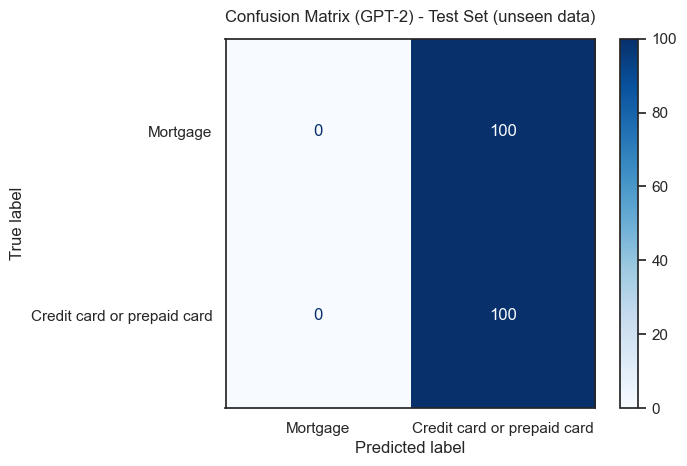

In [12]:
create_confusion_matrix(data = tokenized_dataset_gpt2,
                        cl_classes= product_classes,
                        trainer_ = gpt2_trainer,
                        title_text = 'Confusion Matrix (GPT-2) - Test Set (unseen data)')

#### Loading and testing fine-tuned model: GPT-2-lora

In [13]:
# Loading PEFT model: gpt-2-lora
gpt2_peft_model = PeftModel.from_pretrained(base_gpt2_model, gpt2_peft_model_path)
gpt2_peft_model.config.pad_token_id = tokenizer_gpt2.pad_token_id

# Test GPT-2-Lora model on unseen data
gpt2_lora_results, gpt2_lora_trainer = \
	evaluate_model_hf(gpt2_peft_model, tokenized_dataset_gpt2, tokenizer_gpt2)

gpt2_lora_results = pd.DataFrame([gpt2_lora_results])
gpt2_lora_results['model'] = 'GPT2-Lora'

gpt2_lora_results

C:\Users\vtsoumpris\AppData\Local\Temp\ipykernel_23216\533718504.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


,eval_loss,eval_model_preparation_time,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,model
0,0.519709,0.008,0.755,0.752475,0.76,0.756219,5.196,38.491,9.623,GPT2-Lora


#### Confusion Matrix: GPT-2-lora

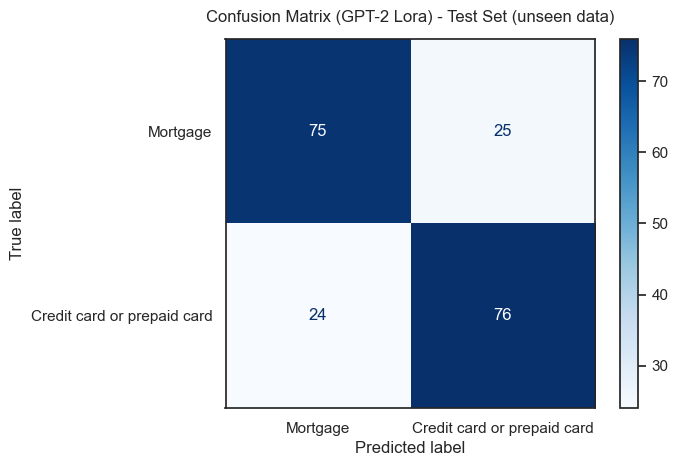

In [14]:
create_confusion_matrix(data = tokenized_dataset_gpt2,
                        cl_classes= product_classes,
                        trainer_ = gpt2_lora_trainer,
                        title_text = 'Confusion Matrix (GPT-2 Lora) - Test Set (unseen data)')

#### Loading and testing fine-tuned model: GPT-2-lora (quantized)

In [15]:
# Loading PEFT model: gpt-2-quantised+lora
gpt2q4_peft_model = PeftModel.from_pretrained(base_gpt2_model, gpt2q4_peft_model_path)
gpt2q4_peft_model.config.pad_token_id = tokenizer_gpt2.pad_token_id

# Test GPT-2-Quantised-Lora model on unseen data
gpt2q4_lora_results, gpt2q4_lora_trainer = \
	evaluate_model_hf(gpt2q4_peft_model, tokenized_dataset_gpt2, tokenizer_gpt2)

gpt2q4_lora_results = pd.DataFrame([gpt2q4_lora_results])
gpt2q4_lora_results['model'] = 'GPT2-QLoRA'

gpt2q4_lora_results

C:\Users\vtsoumpris\AppData\Local\Temp\ipykernel_23216\533718504.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


,eval_loss,eval_model_preparation_time,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,model
0,0.322424,0.006,0.915,0.902913,0.93,0.916256,5.3468,37.406,9.351,GPT2-QLoRA


#### Confusion Matrix: GPT-2-quantized+lora

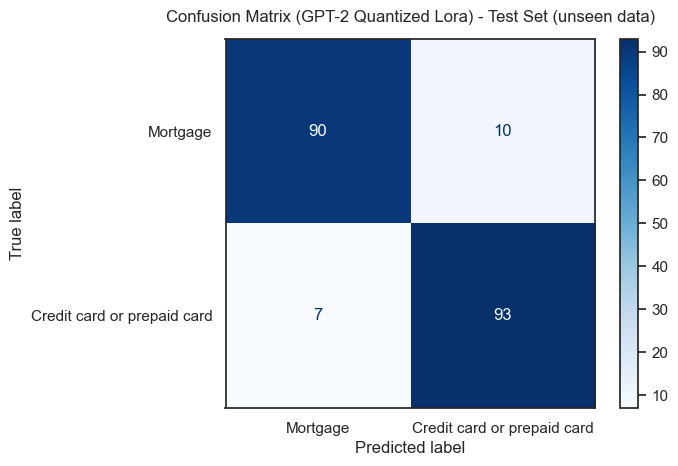

In [16]:
create_confusion_matrix(data = tokenized_dataset_gpt2,
                        cl_classes= product_classes,
                        trainer_ = gpt2q4_lora_trainer,
                        title_text = 'Confusion Matrix (GPT-2 Quantized Lora) - Test Set (unseen data)')

#### Loading and testing model: distil-Bert base

In [17]:
# Load DistilBERT foundation
base_distilbert_model = \
	AutoModelForSequenceClassification.from_pretrained(
		"distilbert-base-uncased",
        num_labels = len(product_classes)
    )

# Test DistilBERT model on unseen data
dbert_results, dbert_trainer = \
	evaluate_model_hf(base_distilbert_model, tokenized_dataset_dbert, tokenizer_dbert)

dbert_results = pd.DataFrame([dbert_results])
dbert_results['model'] = 'dbert'

dbert_results

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\vtsoumpris\AppData\Local\Temp\ipykernel_23216\533718504.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


,eval_loss,eval_model_preparation_time,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,model
0,0.696661,0.002,0.5,0.5,0.01,0.019608,1.0434,191.679,47.92,dbert


#### Confusion Matrix: distilBert base

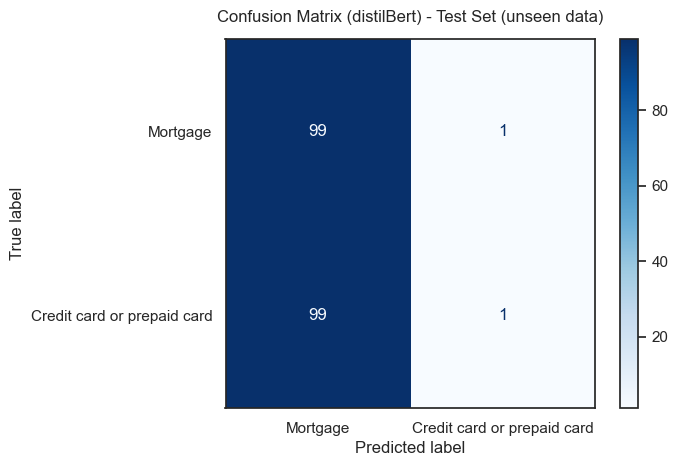

In [18]:
create_confusion_matrix(data = tokenized_dataset_dbert,
                        cl_classes= product_classes,
                        trainer_ = dbert_trainer,
                        title_text = 'Confusion Matrix (distilBert) - Test Set (unseen data)')

#### Loading and testing fine-tuned model: distil-Bert-lora

In [19]:
# Loading PEFT model: DistilBERT-lora
distilbert_peft_model = PeftModel.from_pretrained(base_distilbert_model, distilbert_peft_model_path)

# Test DistilBERT-Lora model on unseen data
dbert_lora_results, dbert_lora_trainer = \
	evaluate_model_hf(distilbert_peft_model, tokenized_dataset_dbert, tokenizer_dbert)

dbert_lora_results = pd.DataFrame([dbert_lora_results])
dbert_lora_results['model'] = 'dbert-Lora'

dbert_lora_results

C:\Users\vtsoumpris\AppData\Local\Temp\ipykernel_23216\533718504.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


,eval_loss,eval_model_preparation_time,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,model
0,0.268136,0.004,0.94,0.892857,1.0,0.943396,0.9661,207.017,51.754,dbert-Lora


#### Confusion Matrix: distilBert-lora

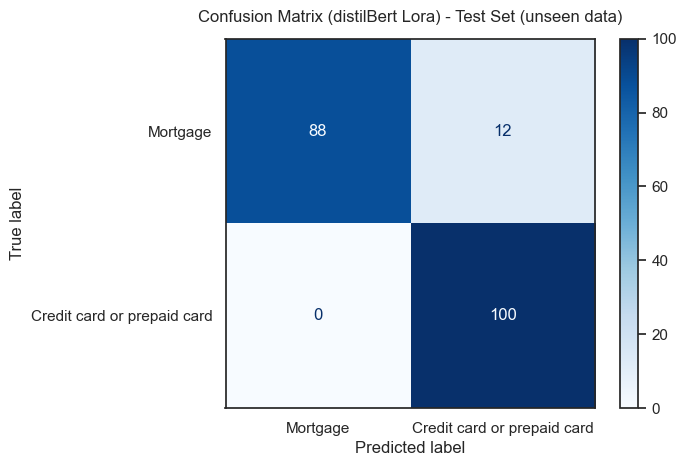

In [20]:
create_confusion_matrix(data = tokenized_dataset_dbert,
                        cl_classes= product_classes,
                        trainer_ = dbert_lora_trainer,
                        title_text = 'Confusion Matrix (distilBert Lora) - Test Set (unseen data)')

#### Assembling all results into one pandas dataframe

In [21]:
all_results = pd.concat([gpt2_results,
                         gpt2_lora_results,
                         gpt2q4_lora_results,
                         dbert_results,
                         dbert_lora_results])

finetuned_results = pd.concat([gpt2_lora_results,gpt2q4_lora_results,dbert_lora_results])



all_results[['model', 'eval_accuracy','eval_precision','eval_recall','eval_f1']]

,model,eval_accuracy,eval_precision,eval_recall,eval_f1
0,GPT2,0.500,0.500000,1.00,0.666667
0,GPT2-Lora,0.755,0.752475,0.76,0.756219
0,GPT2-QLoRA,0.915,0.902913,0.93,0.916256
0,dbert,0.500,0.500000,0.01,0.019608
0,dbert-Lora,0.940,0.892857,1.00,0.943396


### Plotting performance metrics per model

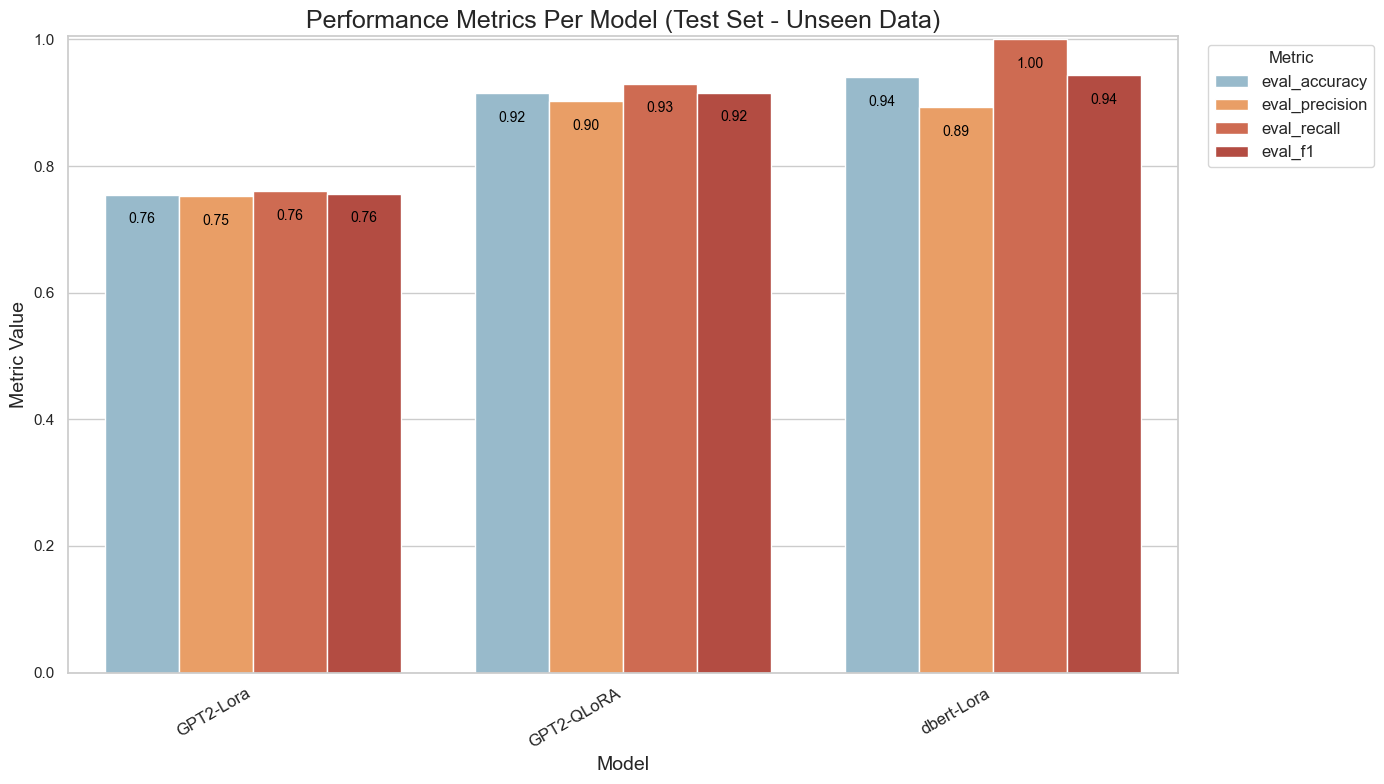

In [24]:
used_df = finetuned_results

# Add a new column for the average of eval_accuracy and eval_f1
used_df['avg_acc_f1'] = (used_df['eval_accuracy'] + used_df['eval_f1']) / 2

# Sort the DataFrame by the average column
used_df = used_df.sort_values(by = 'avg_acc_f1', ascending = True)

# Drop the average column if it's not needed for plotting
used_df = used_df.drop(columns = ['avg_acc_f1'])

# Melting the DataFrame for easier plotting with Seaborn
melted_results = used_df.melt(id_vars = 'model',
                              value_vars = ['eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1'],
                              var_name = 'metric',
                              value_name = 'value'
                              )

# Set Seaborn style and define a custom palette
sns.set_theme(style = "whitegrid")
palette = sns.color_palette(["#8FBDD3", "#FF9B50", "#E25E3E", "#C63D2F"])

# Create the plot
plt.figure(figsize = (14, 8))
barplot = sns.barplot(data = melted_results,
                      x = 'model',
                      y = 'value',
                      hue = 'metric',
                      palette = palette
                      )

# Add metric values inside the bars
for bar, value in zip(barplot.patches, melted_results['value']):
	text_x = bar.get_x() + bar.get_width() / 2  # Center the text in the bar
	text_y = bar.get_height()  # Position at the top of the bar
	barplot.text(text_x, text_y - 0.05, f'{value:.2f}', ha = 'center', va = 'bottom', color = 'black', fontsize = 10)

# Customizations
plt.title('Performance Metrics Per Model (Test Set - Unseen Data)', fontsize = 18)
plt.xlabel('Model', fontsize = 14)
plt.ylabel('Metric Value', fontsize = 14)
plt.xticks(rotation = 30, ha = 'right', fontsize = 12)

# Move the legend outside the plot
plt.legend(title = 'Metric', fontsize = 12, bbox_to_anchor = (1.02, 1), loc = 'upper left')

# Adjust the y-axis to make space for values
plt.ylim(0, 1.005)  # Metrics range slightly above 1 for better visibility of text
plt.tight_layout()

# Show the plot
plt.show()